In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm, trange
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)
from importlib import reload

import oscdetector as od

def read_current_time():
    from datetime import datetime
    now = datetime.now()

    return "%d%02d%02d-%02d:%02d:%02d"%(now.year, now.month, now.day,
                                        now.hour, now.minute, now.second)

In [3]:
tag = "_mfast"
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data"+tag, load_only_control=True)

srate = 2000

# Tune detection frequency range

In [93]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def f_cauchy(x, a0, x0, g0):
    return a0/np.pi*(g0/((x-x0)**2+g0**2))

def f_cauchy2(x, a0, x0, g0, a1, x1, g1):
    y0 = f_cauchy(x, a0, x0, g0)
    y1 = f_cauchy(x, a1, x1, g1)
    return y0 + y1


def fit_distrib2(x, y):
    idp, _ = find_peaks(y, distance=5, prominence=0.1)
    
    if len(idp) == 2:
        raise NotImplementedError("")
    elif len(idp) == 1:
        params, _ = curve_fit(f_cauchy, x, y, p0=(1, x[idp[0]], 1))
    else:
        raise ValueError("")
        
    return params
    
amp_range_set = []

In [97]:
cid = 8

yf = [0, 0]
ntrial = 20
for n in range(ntrial):
    detail_data = summary_obj.load_detail(cid-1, n)
    psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(10, 100), mbin_t=0.01, wbin_t=0.5, srate=srate)
    yf[0] += psd_set[1].mean(axis=1)
    yf[1] += psd_set[2].mean(axis=1)
yf[0] /= ntrial
yf[1] /= ntrial

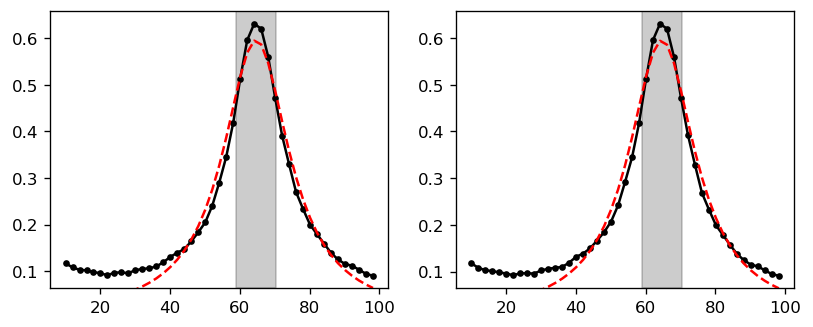

{'fop': [[], (58.8476633675717, 70.47084691800538)], 'spop': [[], (58.82360107646549, 70.46999337592582)]}


In [98]:
c = 0.5

keys = ("fop", "spop")
amp_range = dict()

fig, axs = plt.subplots(1,2,figsize=(8, 3))
for n in range(2):
    ax = axs[n]
    ax.plot(fpsd, yf[n], 'k.-')
    pfit = fit_distrib2(fpsd, yf[n])
    
    amp_range[keys[n]] = [[], []]
    yl = ax.get_ylim()
    if len(pfit) == 3:
        ax.plot(fpsd, f_cauchy(fpsd, *pfit), 'r--')
        fl = (pfit[1]-c*pfit[2], pfit[1]+c*pfit[2])
        ax.fill_betweenx(yl, fl[0], fl[1], color='k', alpha=0.2)
        amp_range[keys[n]][1] = fl

    ax.set_ylim(yl)
    
plt.show()
print(amp_range)

In [100]:
key_names = ("fpop", "spop")

amp_range_set = [
    dict(fpop=[[], [30, 50]], spop=[[], [30, 50]]), # 1
    dict(fpop=[[], [25, 50]], spop=[[], [25, 50]]), # 2
    dict(fpop=[[], [30, 50]], spop=[[], [30, 50]]), # 3
    dict(fpop=[[], [47, 70]], spop=[[], [47, 70]]), # 4
    dict(fpop=[[], [47, 70]], spop=[[], [47, 70]]), # 5
    dict(fpop=[[], [54, 76]], spop=[[], [54, 76]]), # 6
    dict(fpop=[[], [60, 75]], spop=[[], [60, 75]]), # 7
    dict(fpop=[[], [60, 70]], spop=[[], [60, 70]]), # 8
]

with open("./data/osc_motif%s/amp_range_set.pkl"%(tag), "wb") as fp:
    pkl.dump({"amp_range_set": amp_range_set,
              "last-updated": read_current_time()}, fp)
    
# frequency range are determined based on fourier transform result

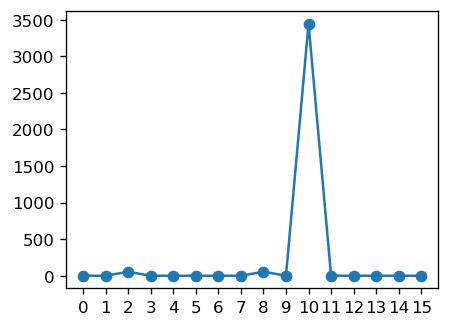

In [118]:
import utils

cid = 8
motif_data = utils.load_pickle("./data/osc_motif_mfast/motif_info_%d.pkl"%(cid))

plt.figure(figsize=(4, 3))
plt.plot(np.arange(16), [len(w) for w in motif_data["winfo"]], 'o-')
plt.xticks(np.arange(16))
plt.show()

In [232]:
cid, nitr = 1, 1

detail_data = summary_obj.load_detail(cid-1, nitr)
psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(10, 100), mbin_t=0.01, wbin_t=0.5, srate=srate)

winfo = utils.load_pickle("./data/osc_motif_mfast/motif_info_%d.pkl"%(cid))["winfo"]

In [236]:
reload(utils)

winfo, update_date = utils.load_osc_motif(1, 2, reverse=False)

Loaded oscillation motif information udpated in 20240714


In [268]:
winfo = utils.load_pickle("./data/osc_motif_mfast/motif_info_%d.pkl"%(cid))["winfo"]

nt_prv = -1

yf = []
for nt, tl in tqdm(winfo[2][:100]):
    if nt != nt_prv:
        detail_data = summary_obj.load_detail(cid-1, nt)
        psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(10, 100), mbin_t=0.01, wbin_t=0.5, srate=srate)
        m = psd_set[1].mean(axis=1, keepdims=True)
        nt_prv = nt
    
    idt = (tpsd >= tl[0]) & (tpsd <= tl[1])
    yf.append(psd_set[1][:,idt]-m)
    
yf_cat = np.hstack(yf)

  0%|          | 0/100 [00:00<?, ?it/s]

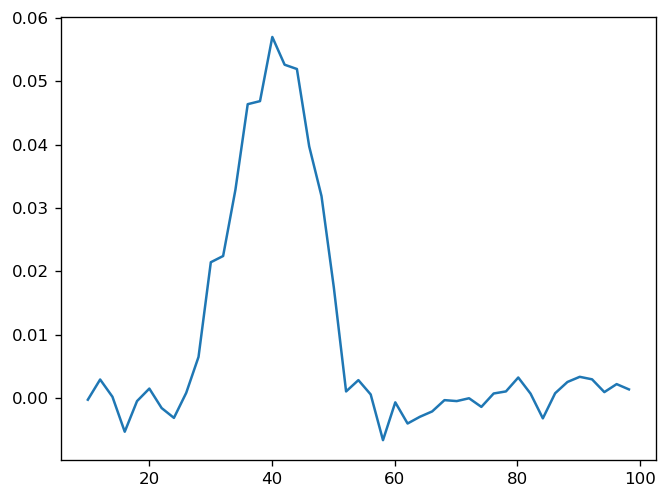

In [269]:
plt.plot(fpsd, yf_cat.mean(axis=1))

Loaded oscillation motif information udpated in 20240714


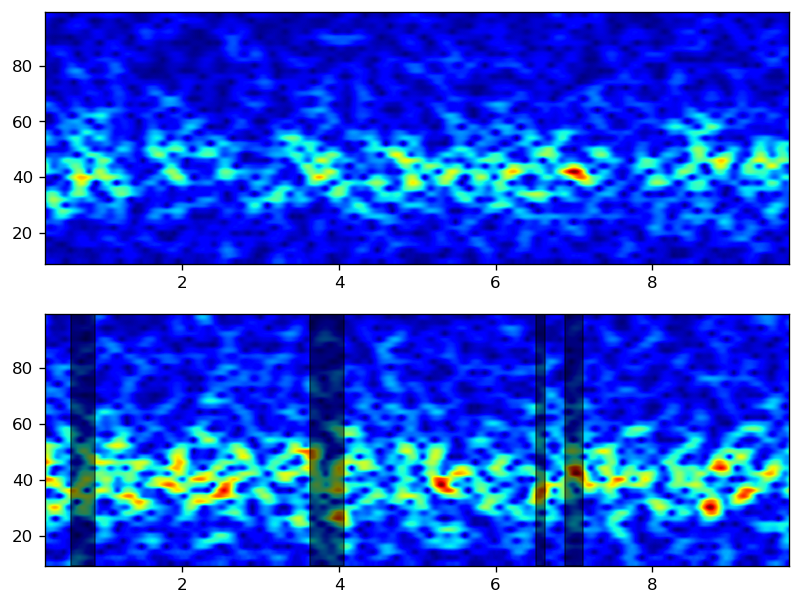

In [167]:
fig, axs = plt.subplots(2,1,figsize=(8,6))
plt.sca(axs[0])
hhtools.imshow_xy(psd_set[1], x=tpsd, y=fpsd, cmap="jet")

plt.sca(axs[1])
hhtools.imshow_xy(psd_set[2], x=tpsd, y=fpsd, cmap="jet")

yf = []

yl = plt.ylim()
for w in [winfo]:
    for n, tl in w:
        if n != nitr: continue
        plt.fill_between(tl, yl[0], yl[1], color='k', alpha=0.5)
        
        idt = (tpsd >= tl[0]) & (tpsd <= tl[1])
        yf.append(psd_set[2][:,idt])
        
    
plt.ylim(yl)

plt.show()

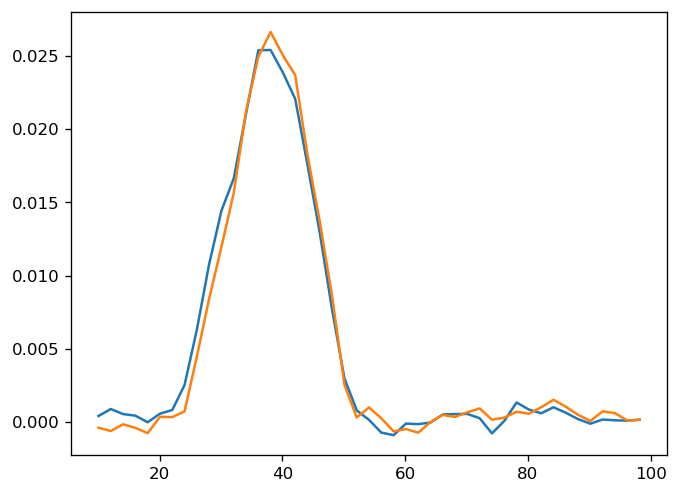

In [295]:
spec = utils.load_pickle("./data/spec_mfast/spec_210.pkl")

plt.plot(spec["fpsd"], spec["spec_boot"].mean(axis=0)[0])
plt.plot(spec["fpsd"], spec["spec_boot"].mean(axis=0)[1])

Loaded oscillation motif information udpated in 20240714


In [142]:
len(winfo)

1964

In [106]:
len(winfo["winfo"])

16

# Detect oscillation motif - sample

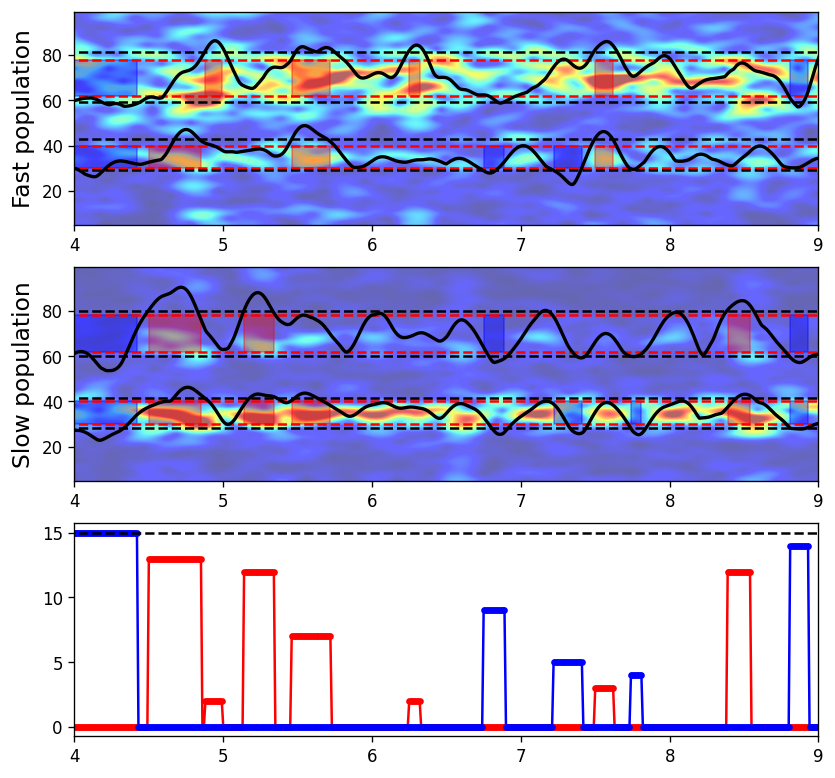

ratio of positive motif: 0.200 and negative motif: 0.189


In [130]:
reload(od)

xl = [4, 9]
q = 90

words_p = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=q, min_len=2, cat_th=2)
words_n = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=100-q, min_len=2, cat_th=2, reversed=True)

# Draw figure
fig, axs = plt.subplots(3,1,figsize=(8, 8), dpi=120)

# image option
im_opt = dict(cmap="jet", alpha=0.6, interpolation="bicubic")

for n in range(2):
    tp  = "fpop" if n == 0 else "spop"
    ylb = "Fast population" if n == 0 else "Slow population"
    plt.axes(axs[n])
    hhtools.imshow_xy(psd_set[n+1], x=tpsd, y=fpsd, **im_opt)
    plt.ylabel(ylb, fontsize=14)

    # Draw line for visualizing average oscillatory activity
    for i in range(2):
        fr = amp_range[tp][i]
        if len(fr) == 0: continue
        axs[n].hlines(fr[0], tpsd[0], tpsd[-1], color='r', linestyle='--')
        axs[n].hlines(fr[1], tpsd[0], tpsd[-1], color='r', linestyle='--')

        # get target frequency activity
        y = psd_set[n+1][(fpsd >= fr[0]) & (fpsd < fr[1])].mean(axis=0)
        a, b = (fr[1]-fr[0])/2, (fr[1]+fr[0])/2
        yn = a * (y - y.mean())/y.std() + b
    
        # get threshold
        yn_th_min = np.percentile(yn, 100-q)
        yn_th_max = np.percentile(yn, q)
        
        axs[n].plot(tpsd, yn, c='k', lw=2)
        axs[n].hlines(yn_th_min, tpsd[0], tpsd[-1], color='k', linestyle='--')
        axs[n].hlines(yn_th_max, tpsd[0], tpsd[-1], color='k', linestyle='--')

    # Fill the range of oscillation motif
    for words, cs in zip([words_p, words_n], ["r", "b"]):
        for motif in od.get_motif_boundary(words, tpsd):
            idx = od.dec2bin(motif["id"], digit=4)
            tl  = motif["range"]
            
            for m in range(4):
                i = m // 2
                j = m % 2
                tp = "fpop" if i ==0 else "spop"
        
                fl = amp_range[tp][j]
                if idx[m]:
                    axs[i].fill_between(tl, [fl[0]]*2, [fl[1]]*2, edgecolor="none", color=cs, alpha=0.2)

    
axs[2].plot(tpsd, words_p, '.-', c='r')
axs[2].plot(tpsd, words_n, '.-', c='b')
axs[2].plot([tpsd[0], tpsd[-1]], [15, 15], 'k--')

for i in range(3):
    axs[i].set_xlim(xl)

plt.show()

tlen_p = sum([motif["range"][1]-motif["range"][0] for motif in od.get_motif_boundary(words_p, tpsd)])
tlen_n = sum([motif["range"][1]-motif["range"][0] for motif in od.get_motif_boundary(words_n, tpsd)])
tlen_total = tpsd[-1] - tpsd[0]

print("ratio of positive motif: %.3f and negative motif: %.3f"%(tlen_p/tlen_total, tlen_n/tlen_total))

# Count the number of oscillation motif

In [14]:
target_cid = [5, 8]
num_f = 47

word_counts = np.zeros((len(target_cid), 16))
word_length = np.zeros((len(target_cid), 16))
word_spec = np.zeros((len(target_cid), 16, 2, num_f))

# joint_map = np.zeros([2, 16, 2, num_f, num_f]) # clusterID, wordID, fast/slow pop
for nc, cid in enumerate([5, 8]):
    amp_range = amp_range_set[cid-1]
    
    for i in trange(200):
        detail_data = summary_obj.load_detail(cid-1, i)
        psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=0.01, wbin_t=0.5)
        words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=80, min_len=2, cat_th=2)
        # words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=70, min_len=2, cat_th=2)
        # words = od.compute_osc_trit(psd_set[1:], fpsd, tpsd, amp_range, q=70, min_len=2, cat_th=2)
        # word_counts[nc] += od.count_motif(words)
        wc, wl = od.count_motif(words)
        word_counts[nc] += wc
        word_length[nc] += wl

        # average power spectrogram
        psd_set = np.array(psd_set)
        word_spec[nc, 0] += psd_set[1:].mean(axis=2)

        for motif in od.get_motif_boundary(words, np.arange(tpsd.shape[0])):
            nw = motif["id"]
            nrange = motif["range"]
            word_spec[nc, nw] += psd_set[1:,:,nrange[0]:nrange[1]].sum(axis=2)

    word_spec[nc, 0] /= 200
    for nw in range(1, 16):
        word_spec[nc, nw] /= word_length[nc, nw]
    
    word_counts[nc] /= 200
    word_length[nc] /= 200*len(tpsd)

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_19920/2332716989.py:34: RuntimeWarning: divide by zero encountered in divide
  word_spec[nc, nw] /= word_length[nc, nw]
/tmp/ipykernel_19920/2332716989.py:34: RuntimeWarning: invalid value encountered in divide
  word_spec[nc, nw] /= word_length[nc, nw]


  0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
16/200

0.08

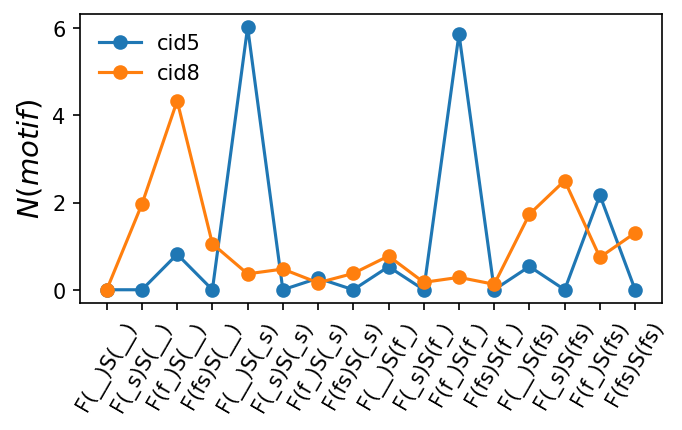

Count: 16, 16


In [15]:
plt.figure(figsize=(5, 2.5), dpi=150)
plt.plot(word_counts[0], 'o-', label="cid5")
plt.plot(word_counts[1], 'o-', label="cid8")
plt.xticks(np.arange(16), od.get_motif_labels(), rotation=60)
plt.legend(loc="upper left", edgecolor="none")
plt.ylabel(r"$N(motif)$", fontsize=14)
plt.show()

print("Count: %d, %d"%(sum(word_counts[0]), sum(word_counts[1])))

In [9]:
cs = [["#990303", "#0f0acc"], ["#e30404", "#3a8ede"]]

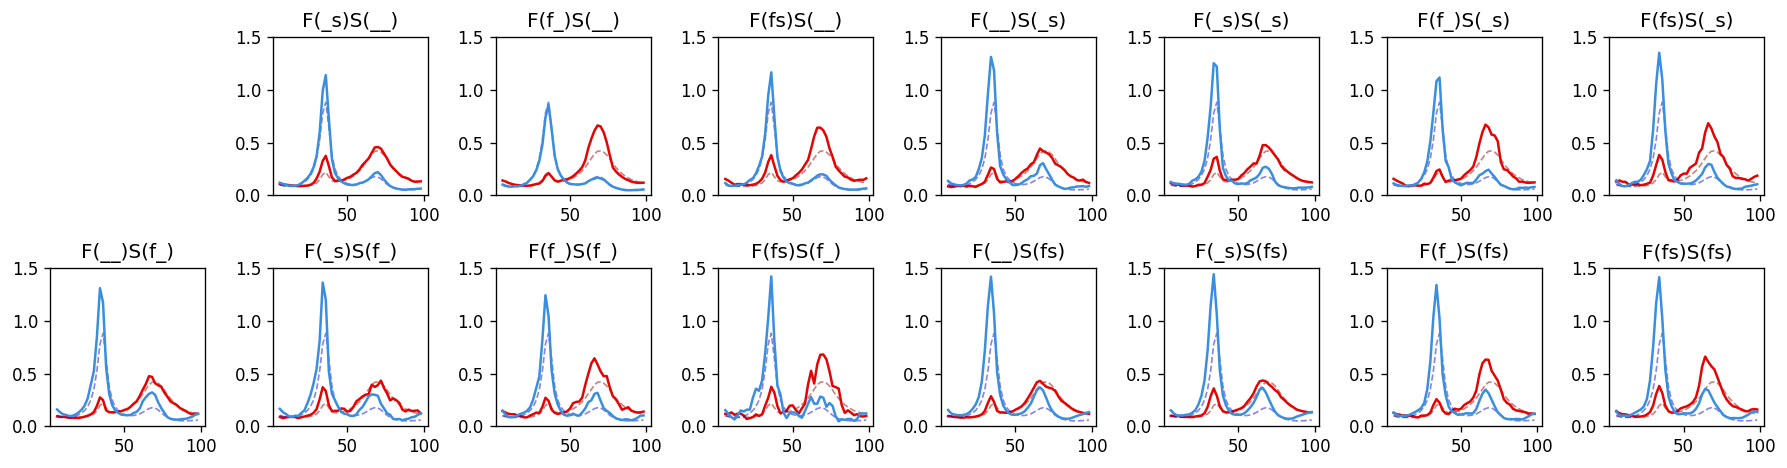

In [10]:
nc = 1

titles = od.get_motif_labels()
plt.figure(figsize=(15, 4))
for nw in range(1, 16):
    plt.subplot(2,8,nw+1)
    for i in range(2):
        plt.plot(fpsd, word_spec[nc,0,i], '--', c=cs[0][i], alpha=0.5, lw=1.)
        plt.plot(fpsd, word_spec[nc,nw,i], c=cs[1][i], alpha=1, lw=1.5)
    plt.title(titles[nw], fontsize=12)
    plt.ylim([0, 1.5])
    
plt.tight_layout()    
plt.show()

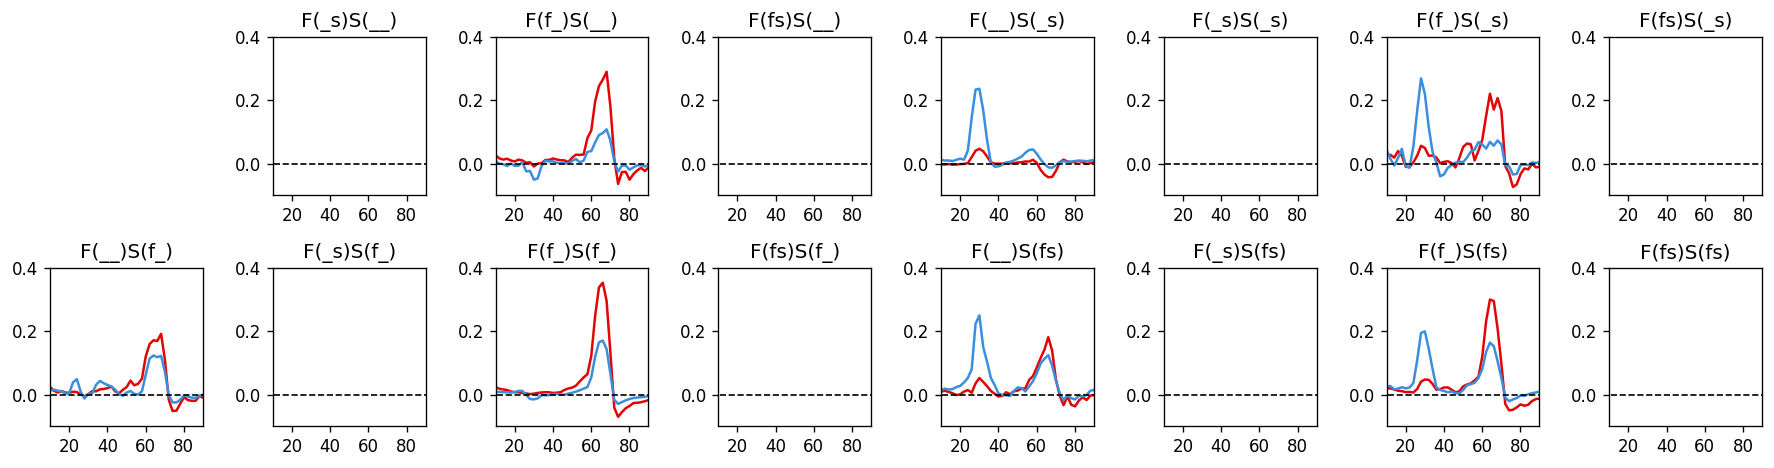

In [11]:
nc = 0

titles = od.get_motif_labels()
plt.figure(figsize=(15, 4))
for nw in range(1, 16):
    plt.subplot(2,8,nw+1)
    for i in range(2):
        # plt.plot(fpsd, word_spec[nc,0,i], '--', c=cs[0][i], alpha=0.5, lw=1.)
        plt.plot(fpsd, word_spec[nc,nw,i]-word_spec[nc,0,i], c=cs[1][i], alpha=1, lw=1.5)
    plt.plot([fpsd[0], fpsd[-1]], [0, 0], 'k--', lw=1)
    plt.title(titles[nw], fontsize=12)
    plt.xticks(np.arange(0, 105, 20))
    plt.xlim([10, 90])
    plt.ylim([-.1, 0.4])
    
plt.tight_layout()    
plt.show()

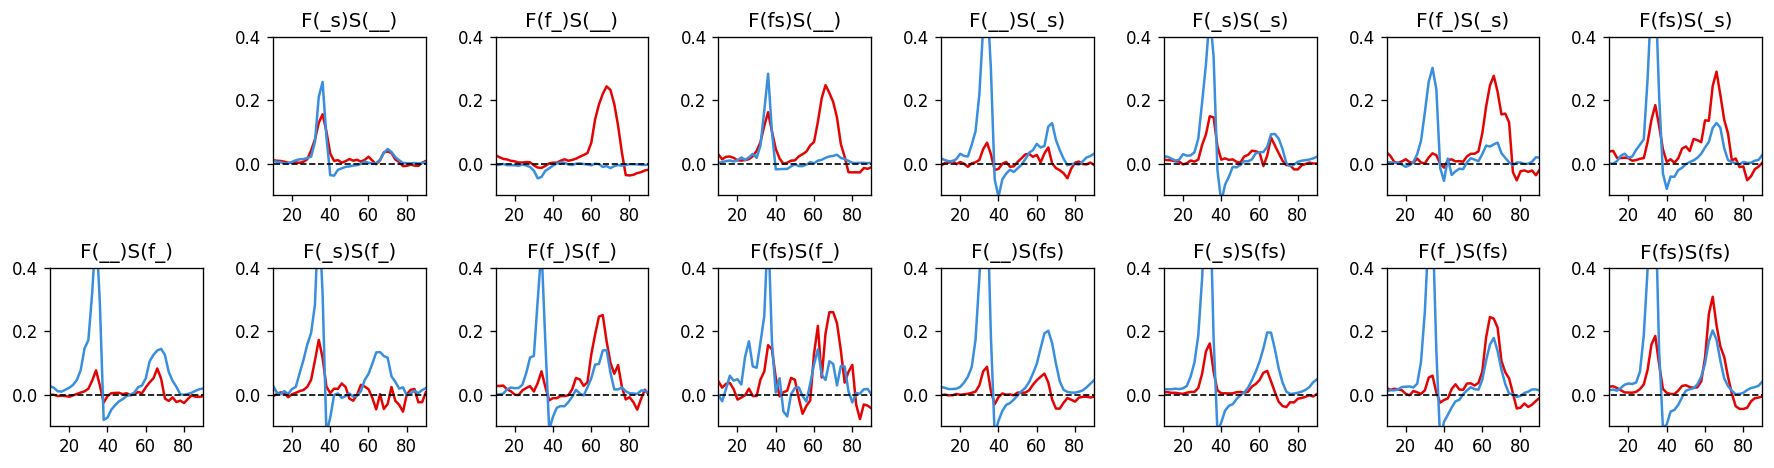

In [12]:
nc = 1

titles = od.get_motif_labels()
plt.figure(figsize=(15, 4))
for nw in range(1, 16):
    plt.subplot(2,8,nw+1)
    for i in range(2):
        # plt.plot(fpsd, word_spec[nc,0,i], '--', c=cs[0][i], alpha=0.5, lw=1.)
        plt.plot(fpsd, word_spec[nc,nw,i]-word_spec[nc,0,i], c=cs[1][i], alpha=1, lw=1.5)
    plt.plot([fpsd[0], fpsd[-1]], [0, 0], 'k--', lw=1)
    plt.title(titles[nw], fontsize=12)
    plt.xticks(np.arange(0, 105, 20))
    plt.ylim([-.1, 0.4])
    plt.xlim([10, 90])
    
plt.tight_layout()    
plt.show()

In [ ]:
nc = 0

plt.figure(figsize=(15, 4))
for nw in range(1, 16):
    plt.subplot(2,8,nw+1)
    for i in range(2):
        plt.plot(fpsd, word_spec[nc,0,i], '--', c=cs[0][i], alpha=0.5, lw=1.)
        plt.plot(fpsd, word_spec[nc,nw,i], c=cs[1][i], alpha=1, lw=1.5)
        
plt.show()

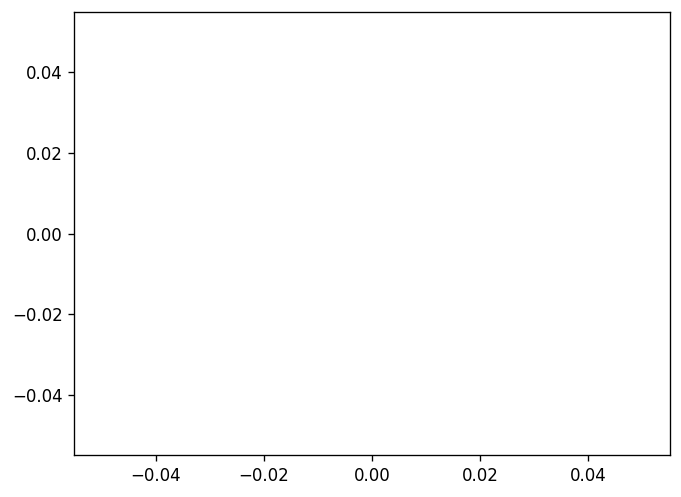

In [28]:
plt.figure()
plt.plot(word_spec[0,15].T)

In [14]:
word_spec.shape

(2, 16, 2, 47)

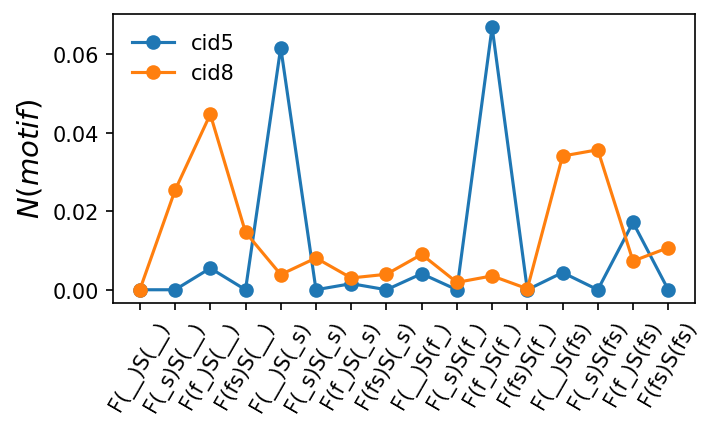

Count: 11, 12


In [7]:
plt.figure(figsize=(5, 2.5), dpi=150)
plt.plot(word_length[0], 'o-', label="cid5")
plt.plot(word_length[1], 'o-', label="cid8")
plt.xticks(np.arange(16), od.get_motif_labels(), rotation=60)
plt.legend(loc="upper left", edgecolor="none")
plt.ylabel(r"$N(motif)$", fontsize=14)
plt.show()

print("Count: %d, %d"%(sum(word_counts[0]), sum(word_counts[1])))

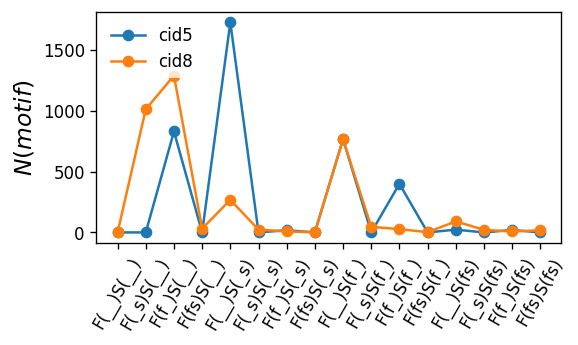

Count: 3789, 3616


In [63]:
plt.figure(figsize=(5, 2.5))
plt.plot(word_counts[0], 'o-', label="cid5")
plt.plot(word_counts[1], 'o-', label="cid8")
plt.xticks(np.arange(16), od.get_motif_labels(), rotation=60)
plt.legend(loc="upper left", edgecolor="none")
plt.ylabel(r"$N(motif)$", fontsize=14)
plt.show()

print("Count: %d, %d"%(sum(word_counts[0]), sum(word_counts[1])))

# Oscillation motif sample

In [41]:
cid, nitr  = 8, 20

detail_data = summary_obj.load_detail(cid-1, nitr)
amp_range  = amp_range_set[cid-1]

psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=0.01, wbin_t=0.5)
words = od.compute_osc_trit(psd_set[1:], fpsd, tpsd, amp_range, q=70, min_len=2, cat_th=2)
motif = od.get_motif_boundary(words, tpsd)

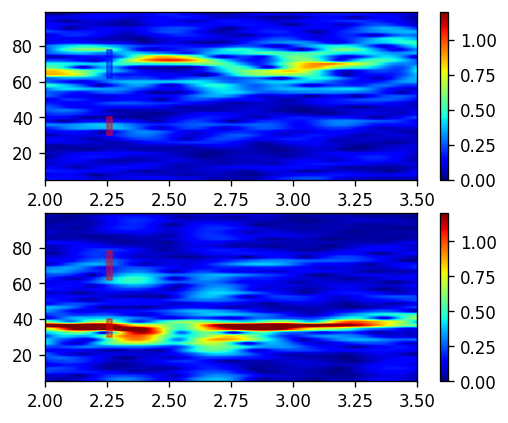

In [57]:
xl = [2., 3.5]

fig, axs = plt.subplots(2,1,figsize=(5, 4), dpi=120)

for i in range(2):
    plt.axes(axs[i])
    # plt.subplot(2,1,i+1)
    hhtools.imshow_xy(psd_set[i+1], x=tpsd, y=fpsd, cmap="jet", vmin=0, vmax=1.2)
    plt.xlim(xl)
    plt.colorbar()

yl = [fpsd[0], fpsd[-1]]

for motif in od.get_motif_boundary(words, tpsd):
    idx = od.dec2bin(motif["id"], 4)
    tl  = motif["range"]

    for n in range(4):
        i = n // 2
        j = n % 2
        tp = "fpop" if i ==0 else "spop"

        fl = amp_range[tp][j]
        if idx[n]:
            axs[i].fill_between(tl, [fl[0]]*2, [fl[1]]*2, edgecolor="none", color="r", alpha=0.5)
        else:
            axs[i].fill_between(tl, [fl[0]]*2, [fl[1]]*2, edgecolor="none", color="b", alpha=0.5)
    
plt.show()

In [48]:
tl

array([8.16, 8.27])

# Oscillation motif sample

In [98]:
reload(od)
amp_range = dict(fpop=[[30, 40], [65, 75]],
                 spop=[[30, 40], [65, 75]])
words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=75, min_len=2, cat_th=4)

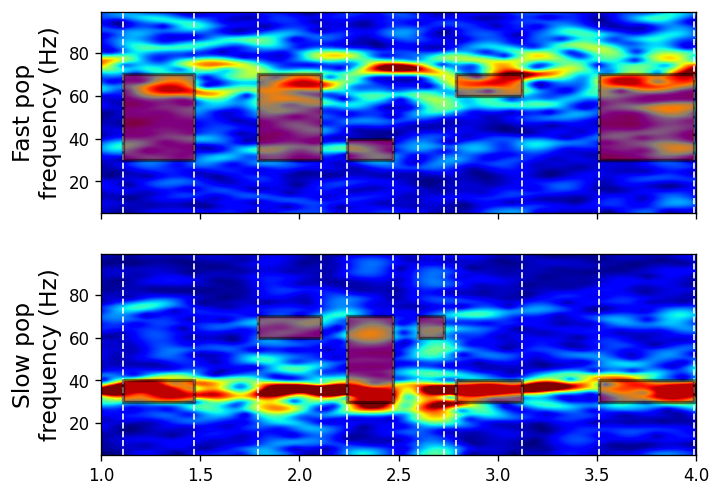

In [155]:
cid = 8
amp_range = amp_range_set[cid-1]
# amp_range = dict(fpop=[[], [60, 70]],
#             spop=[[20, 30], [60, 70]]) # 5 -> tuned

detail_data =summary_obj.load_detail(cid-1, 20)
psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=0.01, wbin_t=0.5)
words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=75, min_len=2, cat_th=4)

tp_labels = ("Fast pop", "Slow pop")

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

for i in range(2):
    plt.axes(axs[i])
    hhtools.imshow_xy(psd_set[i+1], x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic", vmax=0.8)
    plt.ylabel("%s\nfrequency (Hz)"%(tp_labels[i]), fontsize=14)
yl_p = plt.ylim()

osc_motif = od.get_motif_boundary(words, tpsd)
for n in range(len(osc_motif)):
    idx = od.dec2bin(osc_motif[n]["id"], 4)
    xl = osc_motif[n]["range"]

    for i in range(2):
        tp = "fpop" if i == 0 else "spop"
        if idx[2*i] and idx[2*i+1]:
            yl = [amp_range[tp][0][0], amp_range[tp][1][1]]
        else:
            if idx[2*i]:
                yl = amp_range[tp][0]
            elif idx[2*i+1]:
                yl = amp_range[tp][1]
            else:
                yl = []
        
        if not yl:
            continue
        else:
            axs[i].fill_between(xl, [yl[0], yl[0]], [yl[1], yl[1]], facecolor="r", alpha=0.5, edgecolor="k", linewidth=2)
    
    for i in range(2):
        axs[i].plot([xl[0], xl[0]], yl_p, 'w--', lw=1, zorder=0)
        axs[i].plot([xl[1], xl[1]], yl_p, 'w--', lw=1, zorder=0)
    
axs[0].set_ylim(yl_p)
axs[1].set_xlim([1, 4])

plt.show()

# Oscillation motif statistics

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [147]:
od.get_motif_boundary(words, tpsd)

[{'id': 13, 'range': array([1.56, 1.71])},
 {'id': 5, 'range': array([2.36, 2.42])},
 {'id': 15, 'range': array([2.61, 3.  ])},
 {'id': 15, 'range': array([3.08, 3.38])},
 {'id': 15, 'range': array([4.51, 5.03])},
 {'id': 15, 'range': array([5.12, 5.75])},
 {'id': 8, 'range': array([5.97, 6.07])},
 {'id': 2, 'range': array([6.22, 6.42])},
 {'id': 8, 'range': array([6.54, 6.66])},
 {'id': 1, 'range': array([6.98, 7.05])},
 {'id': 4, 'range': array([7.14, 7.19])},
 {'id': 3, 'range': array([7.47, 7.67])},
 {'id': 1, 'range': array([7.91, 7.96])},
 {'id': 4, 'range': array([8.05, 8.1 ])},
 {'id': 15, 'range': array([8.42, 8.63])},
 {'id': 2, 'range': array([9.01, 9.13])}]

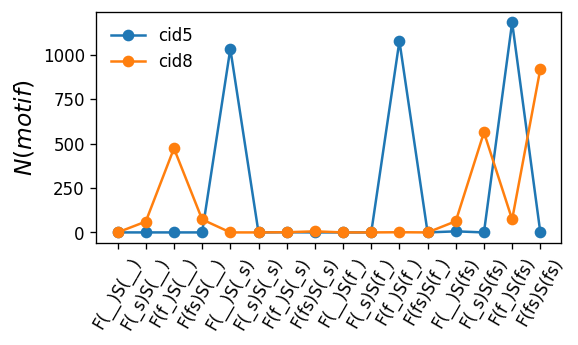